In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `ResizeMix` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom, HoleMakerBounded, HoleMakerAttention
from semantic_segmentation_augmentations.holesfilling import ResizeMix

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "ResizeMix"
}

In order to know how does this technique work, we can show an example:

This technique fills a region with the entire image resized.

In order to do so, the HoleMaker technique used must be `HoleMakerBounded` or `HoleMakerAttention`.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


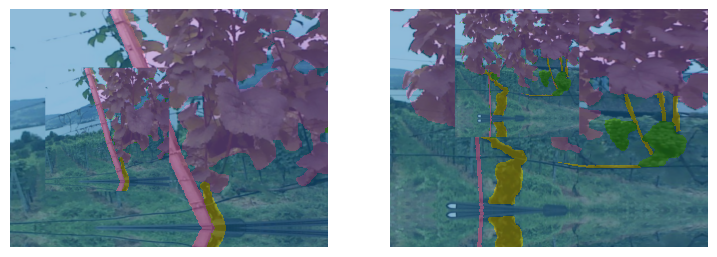

In [ ]:
cmrm = ResizeMix(hole_maker = HoleMakerBounded((250, 250)), p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cmrm) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cmrm.x, cmrm.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2]:
    for size in [(150, 150), (250, 250)]:
        for holemaker in [HoleMakerBounded, HoleMakerAttention]:
            cmrm = ResizeMix(holes_num = holes_num, hole_maker = holemaker(hole_size = size))
            learner_hparams["cbs"] = [esc, cmrm]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode,
                         saving_hparams,
                         verbose = True
                        )
            results.update({
                str(holes_num) + str(size) + str(holemaker).split("'")[1].split(".")[2]: r["DiceMulti"]
            })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.860611,0.654586,0.338382,00:22
1,0.665397,0.435800,0.351736,00:20
2,0.664061,0.562716,0.438578,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.440419,0.348317,0.533686,00:20
1,0.397628,0.338439,0.714952,00:20
2,0.368426,0.278268,0.755619,00:20
3,0.354306,0.281913,0.776463,00:20
4,0.342116,0.254925,0.777850,00:20
5,0.328867,0.301046,0.784674,00:20
6,0.327699,0.295022,0.777513,00:20
7,0.320905,0.253013,0.806583,00:20
8,0.311343,0.268313,0.794392,00:20
9,0.304532,0.250714,0.810140,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.24065664410591125  /  DiceMulti: 0.8222902620264019  
Saving best model because DiceMulti 0.8223 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.924150,0.613773,0.327315,00:20
1,0.667780,0.432562,0.351310,00:20
2,0.825839,0.896353,0.271205,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.552684,0.459451,0.351494,00:20
1,0.482781,0.391912,0.395195,00:20
2,0.462445,0.363048,0.537384,00:20
3,0.413470,0.324521,0.574079,00:20
4,0.380042,0.302421,0.687430,00:20
5,0.386680,0.325612,0.703748,00:20
6,0.366333,0.321597,0.749264,00:20
7,0.352538,0.331665,0.661492,00:20
8,0.335477,0.266422,0.791460,00:20
9,0.312871,0.281088,0.778519,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.19866101443767548  /  DiceMulti: 0.8480386899864486  
Saving best model because DiceMulti 0.848 >= 0.8223.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.912175,0.887088,0.288439,00:20
1,0.726569,0.763814,0.353536,00:20
2,1.027099,0.688278,0.312633,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.560381,0.433969,0.374977,00:20
1,0.509500,0.393705,0.413059,00:20
2,0.459118,0.350056,0.601590,00:20
3,0.423737,0.377114,0.690040,00:20
4,0.390083,0.325244,0.603841,00:20
5,0.365268,0.317448,0.694126,00:20
6,0.340430,0.285768,0.767203,00:20
7,0.328831,0.301041,0.757103,00:20
8,0.317247,0.376850,0.759296,00:20
9,0.310434,0.268674,0.802079,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18601775169372559  /  DiceMulti: 0.8589215937375257  
Saving best model because DiceMulti 0.8589 >= 0.848.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.116032,0.799341,0.324201,00:20
1,0.821956,0.515587,0.346590,00:20
2,0.662012,0.652620,0.282020,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.423963,0.293273,0.604898,00:20
1,0.384017,0.314127,0.676478,00:20
2,0.363604,0.259976,0.680293,00:20
3,0.344817,0.241708,0.774721,00:21
4,0.349767,0.265955,0.682853,00:21
5,0.342477,0.311267,0.787211,00:20
6,0.348384,0.234746,0.818969,00:20
7,0.337632,0.226423,0.821073,00:21
8,0.327967,0.233429,0.825406,00:20
9,0.311376,0.256260,0.761570,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.1828099489212036  /  DiceMulti: 0.8599079062454573  
Saving best model because DiceMulti 0.8599 >= 0.8589.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.812984,0.745859,0.338319,00:20
1,0.622658,0.442484,0.401480,00:20
2,0.539928,0.398299,0.510355,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.391522,0.338684,0.565867,00:21
1,0.357879,0.299234,0.757666,00:20
2,0.336328,0.280913,0.717603,00:21
3,0.317101,0.273728,0.787263,00:21
4,0.312285,0.263175,0.796846,00:21
5,0.318326,0.314203,0.635371,00:20
6,0.318063,0.305372,0.796803,00:20
7,0.322396,0.263234,0.762733,00:20
8,0.304697,0.259876,0.809659,00:21
9,0.288529,0.250435,0.824443,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.23376648128032684  /  DiceMulti: 0.8231549996867662  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.031272,0.650600,0.304000,00:20
1,0.721738,0.823096,0.257282,00:20
2,0.742935,0.949745,0.248355,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.500773,0.569080,0.390791,00:21
1,0.425621,0.459345,0.495817,00:21
2,0.385485,0.448857,0.625318,00:21
3,0.363819,0.445146,0.576352,00:21
4,0.340185,0.401358,0.683312,00:21
5,0.326942,0.547055,0.623583,00:20
6,0.327666,0.502639,0.678796,00:20
7,0.313584,0.390977,0.698281,00:20
8,0.304132,0.477971,0.642455,00:20
9,0.289198,0.401070,0.703073,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.22525951266288757  /  DiceMulti: 0.8413213843872164  
Saving best model because DiceMulti 0.8413 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.947151,0.628052,0.346653,00:20
1,0.722021,0.513171,0.341022,00:20
2,0.681406,0.635642,0.322086,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.493083,0.425798,0.379934,00:20
1,0.461528,0.372456,0.553098,00:21
2,0.411501,0.351335,0.593133,00:21
3,0.373792,0.337854,0.712704,00:20
4,0.354999,0.295354,0.723552,00:21
5,0.331683,0.288503,0.719593,00:20
6,0.313907,0.286929,0.795511,00:20
7,0.313851,0.278917,0.799572,00:21
8,0.311805,0.274068,0.799606,00:20
9,0.305906,0.295477,0.738911,00:20


No improvement since epoch 21: early stopping


Test results for the model.   validation: 0.15570712089538574  /  DiceMulti: 0.8832192341156333  
Saving best model because DiceMulti 0.8832 >= 0.8413.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.895947,0.526097,0.349379,00:20
1,0.640905,0.504558,0.383372,00:20
2,0.552864,0.750962,0.384605,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.441370,0.348266,0.478226,00:21
1,0.385257,0.322302,0.731286,00:21
2,0.350336,0.293904,0.771298,00:21
3,0.329717,0.388732,0.743233,00:21
4,0.327426,0.292700,0.714624,00:21
5,0.318001,0.306366,0.735601,00:21
6,0.310890,0.282406,0.795497,00:20
7,0.295626,0.298810,0.766033,00:21
8,0.279521,0.279403,0.809729,00:21
9,0.283206,0.287134,0.800113,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.1681164801120758  /  DiceMulti: 0.8763665409198508  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.859127,0.710365,0.333517,00:20
1,0.672873,0.368498,0.368110,00:20
2,0.546204,0.336465,0.635383,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.367444,0.256397,0.759618,00:21
1,0.356353,0.243438,0.771240,00:21
2,0.343701,0.267724,0.751491,00:21
3,0.332641,0.236767,0.772279,00:21
4,0.322269,0.237562,0.816837,00:21
5,0.307665,0.239569,0.808335,00:20
6,0.327693,0.284143,0.788552,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.2930818498134613  /  DiceMulti: 0.8074795680031744  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.108558,0.836802,0.256455,00:20
1,0.821051,0.537900,0.358196,00:20
2,0.660029,0.502459,0.347099,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.400761,0.372860,0.512301,00:20
1,0.372822,0.321320,0.633605,00:20
2,0.346109,0.281279,0.739968,00:20
3,0.334849,0.377343,0.721300,00:20
4,0.313177,0.287353,0.751138,00:21
5,0.334036,0.300393,0.784728,00:20
6,0.321410,0.291850,0.725438,00:20
7,0.306263,0.263592,0.781327,00:20
8,0.306184,0.366082,0.762025,00:21
9,0.306879,0.264293,0.814869,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.22167988121509552  /  DiceMulti: 0.8283840719639821  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.788982,0.655320,0.301657,00:20
1,0.572058,0.455252,0.410721,00:20
2,0.543083,0.524837,0.332873,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.371426,0.446951,0.580245,00:21
1,0.337287,0.390766,0.680868,00:21
2,0.311272,0.414370,0.701442,00:21
3,0.302068,0.408833,0.728004,00:21
4,0.304391,0.409967,0.709746,00:21
5,0.292788,0.395100,0.703176,00:21
6,0.280694,0.387089,0.728299,00:21


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.23575839400291443  /  DiceMulti: 0.8271175854670074  
Saving best model because DiceMulti 0.8271 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.957002,0.727801,0.295077,00:20
1,0.665365,0.681667,0.359023,00:20
2,0.724207,1.780434,0.174318,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.823959,0.484375,0.428139,00:21
1,0.582555,0.398855,0.389063,00:21
2,0.497386,0.366814,0.425096,00:21
3,0.443352,0.349748,0.534576,00:21
4,0.403858,0.320636,0.613687,00:21
5,0.374607,0.306110,0.757984,00:21
6,0.356494,0.282704,0.769172,00:21
7,0.359834,0.315372,0.655941,00:21
8,0.344542,0.291846,0.780701,00:21
9,0.330634,0.269354,0.804996,00:21


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.17668265104293823  /  DiceMulti: 0.8643574773979859  
Saving best model because DiceMulti 0.8644 >= 0.8271.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.969682,0.531450,0.339234,00:20
1,0.745711,0.637695,0.321040,00:21
2,0.852219,0.773117,0.299805,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.576357,0.441637,0.353672,00:21
1,0.514284,0.402858,0.440767,00:21
2,0.456378,0.377720,0.536916,00:21
3,0.442718,0.420465,0.537762,00:21
4,0.410418,0.344920,0.642639,00:21
5,0.386620,0.426869,0.504555,00:21
6,0.367789,0.300192,0.728405,00:21
7,0.352107,0.356821,0.715616,00:20
8,0.335616,0.279096,0.791771,00:21
9,0.314355,0.296524,0.758148,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.20832549035549164  /  DiceMulti: 0.7969879654331048  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.085259,0.641803,0.316848,00:20
1,0.752526,0.387286,0.361619,00:21
2,0.825130,0.739281,0.335507,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.522062,0.349428,0.403462,00:21
1,0.466585,0.347335,0.425089,00:21
2,0.449004,0.301364,0.583927,00:21
3,0.426989,0.272619,0.659915,00:21
4,0.398224,0.254638,0.656018,00:21
5,0.381165,0.297433,0.591914,00:21
6,0.368463,0.253687,0.737373,00:21
7,0.345848,0.291825,0.785577,00:21
8,0.334084,0.220237,0.824190,00:21
9,0.312219,0.267223,0.801660,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.20638877153396606  /  DiceMulti: 0.8496408092753706  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.909241,0.633051,0.345533,00:20
1,0.650293,0.433933,0.390525,00:20
2,0.604078,0.440428,0.488426,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.399957,0.341854,0.561590,00:21
1,0.365142,0.304286,0.694737,00:21
2,0.343181,0.285725,0.730713,00:21
3,0.328150,0.277751,0.760627,00:21
4,0.320173,0.263279,0.798508,00:21
5,0.306038,0.261534,0.809161,00:21
6,0.312713,0.263446,0.794798,00:21
7,0.304861,0.292609,0.796444,00:21
8,0.290592,0.247209,0.812830,00:21
9,0.294388,0.274744,0.815189,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.2934763431549072  /  DiceMulti: 0.7500348934953547  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.977672,0.602266,0.316327,00:20
1,0.650483,0.544245,0.373306,00:21
2,0.521919,0.498489,0.442721,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.369006,0.436536,0.585297,00:21
1,0.340596,0.405591,0.680896,00:21
2,0.319314,0.426858,0.678504,00:21
3,0.313189,0.456345,0.618688,00:21
4,0.299821,0.416877,0.690958,00:21
5,0.291208,0.530865,0.701649,00:21
6,0.277379,0.743998,0.688090,00:21


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.27773594856262207  /  DiceMulti: 0.8127724133921698  
Saving best model because DiceMulti 0.8128 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.899529,0.658813,0.344847,00:20
1,0.679638,0.526910,0.388472,00:20
2,0.587152,0.413889,0.415375,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.416840,0.334173,0.579624,00:20
1,0.374639,0.298388,0.712500,00:21
2,0.346733,0.274883,0.767766,00:21
3,0.332994,0.282097,0.753026,00:21
4,0.327196,0.277081,0.792322,00:21
5,0.321162,0.265411,0.789092,00:21
6,0.307431,0.312910,0.748411,00:21
7,0.301103,0.287156,0.794455,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.26542532444000244  /  DiceMulti: 0.8099610334189572  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.962734,0.705974,0.337012,00:20
1,0.678266,0.423133,0.392393,00:20
2,0.716516,0.582783,0.343065,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.486272,0.416703,0.368613,00:21
1,0.439063,0.359147,0.535507,00:21
2,0.407602,0.385745,0.660807,00:21
3,0.397106,0.383029,0.625583,00:21
4,0.367894,0.334442,0.691018,00:21
5,0.343604,0.310191,0.752491,00:21
6,0.318744,0.276664,0.776343,00:20
7,0.320949,0.293365,0.757994,00:21
8,0.329089,0.378043,0.702178,00:21
9,0.318326,0.275637,0.792709,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.18446895480155945  /  DiceMulti: 0.8585474958629378  
Saving best model because DiceMulti 0.8585 >= 0.8128.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.026607,0.600898,0.335181,00:20
1,0.696950,0.519087,0.357307,00:20
2,0.868752,1.205338,0.149416,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.643114,0.385263,0.359429,00:21
1,0.538610,0.351769,0.359715,00:21
2,0.496477,0.375300,0.474805,00:21
3,0.456692,0.275866,0.665257,00:20
4,0.411056,0.283204,0.674273,00:21
5,0.383451,0.255866,0.722473,00:21
6,0.360362,0.257385,0.797479,00:21
7,0.349007,0.231957,0.803398,00:21
8,0.340945,0.246629,0.773366,00:20
9,0.335975,0.304096,0.761974,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.23880000412464142  /  DiceMulti: 0.830964719263345  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.241327,0.860506,0.331554,00:20
1,0.801596,0.621585,0.339097,00:20
2,0.647418,0.498986,0.384498,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.389560,0.360457,0.531427,00:21
1,0.376539,0.354744,0.592855,00:21
2,0.370164,0.353300,0.579728,00:21
3,0.356836,0.319324,0.749957,00:21
4,0.344041,0.297759,0.654252,00:20
5,0.336653,0.286526,0.736120,00:21
6,0.315217,0.267971,0.793431,00:21
7,0.313792,0.283847,0.765196,00:20
8,0.308282,0.258182,0.808844,00:21
9,0.298036,0.264051,0.808619,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.21848803758621216  /  DiceMulti: 0.8300002267371986  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.094964,0.732245,0.282308,00:20
1,0.812319,0.644484,0.299581,00:20
2,0.741974,0.637426,0.320711,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.477527,0.501851,0.385484,00:21
1,0.424666,0.482763,0.450727,00:21
2,0.398997,0.522570,0.563335,00:21
3,0.364110,0.418952,0.658373,00:21
4,0.332216,0.456094,0.659615,00:21
5,0.320885,0.515326,0.452384,00:21
6,0.308781,0.402960,0.712389,00:21
7,0.303739,0.398330,0.718872,00:21
8,0.296439,0.537361,0.711638,00:21
9,0.277636,0.447975,0.719002,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.191991925239563  /  DiceMulti: 0.8577385393208585  
Saving best model because DiceMulti 0.8577 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.944953,0.767214,0.274522,00:20
1,0.675355,0.411026,0.355303,00:20
2,2.418983,34.346447,0.136435,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,7.033362,0.554988,0.350448,00:21
1,2.709992,0.404200,0.494574,00:21
2,1.423975,0.376329,0.509312,00:21
3,0.881455,0.295626,0.731484,00:21
4,0.617717,0.351496,0.704686,00:21
5,0.480077,0.299435,0.764485,00:21
6,0.406298,0.292389,0.752504,00:21
7,0.366593,0.340737,0.720461,00:21
8,0.358482,0.267800,0.800330,00:21
9,0.333761,0.261866,0.816318,00:21


No improvement since epoch 18: early stopping


Test results for the model.   validation: 0.16664865612983704  /  DiceMulti: 0.8770768265704166  
Saving best model because DiceMulti 0.8771 >= 0.8577.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.055952,0.773131,0.330462,00:20
1,0.717451,0.433135,0.370333,00:21
2,0.732199,0.869450,0.305422,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.524061,0.407325,0.550248,00:21
1,0.434541,0.403242,0.563811,00:21
2,0.396634,0.319269,0.687130,00:21
3,0.372830,0.321312,0.680211,00:21
4,0.359781,0.316732,0.673740,00:21
5,0.354702,0.338389,0.590072,00:21
6,0.356081,0.353259,0.711131,00:21
7,0.342666,0.273398,0.796935,00:21
8,0.322727,0.315269,0.772372,00:21
9,0.309248,0.293338,0.790072,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.18907330930233002  /  DiceMulti: 0.8578226713369255  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.986769,0.491668,0.351545,00:21
1,0.699544,0.381223,0.360964,00:21
2,1.872561,1.036540,0.150995,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.624294,0.405786,0.356374,00:21
1,0.524699,0.335063,0.436060,00:21
2,0.478337,0.312772,0.449771,00:21
3,0.448104,0.300382,0.628594,00:21
4,0.418380,0.278525,0.697744,00:21
5,0.388792,0.248078,0.756358,00:21
6,0.365339,0.246815,0.803826,00:21
7,0.343229,0.228185,0.772478,00:21
8,0.336952,0.254612,0.809556,00:21
9,0.339725,0.237737,0.820266,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.20036152005195618  /  DiceMulti: 0.8614280715495456  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.894975,0.920817,0.285526,00:20
1,0.733289,0.509069,0.379577,00:21
2,0.618603,0.456000,0.354935,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.429129,0.378201,0.443189,00:21
1,0.396420,0.350186,0.562694,00:21
2,0.388106,0.311096,0.687805,00:21
3,0.367115,0.291495,0.735461,00:21
4,0.347787,0.277327,0.779937,00:21
5,0.334782,0.290216,0.764015,00:21
6,0.330260,0.302280,0.742924,00:21
7,0.316802,0.275090,0.810075,00:21
8,0.317648,0.343027,0.810245,00:21
9,0.330442,0.276224,0.787094,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.33104172348976135  /  DiceMulti: 0.7439111357235301  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.961759,0.687062,0.318252,00:20
1,0.653745,0.588759,0.358054,00:20
2,0.640215,0.575813,0.336712,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.406181,0.487444,0.536531,00:21
1,0.380756,0.463573,0.602733,00:21
2,0.352489,0.402979,0.601821,00:20
3,0.335027,0.413367,0.634778,00:21
4,0.322687,0.420753,0.671440,00:21
5,0.311735,0.573363,0.680166,00:21
6,0.301993,0.414583,0.699266,00:21
7,0.285913,0.391443,0.709450,00:21
8,0.285721,0.406608,0.715810,00:21
9,0.271948,0.351290,0.751026,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.19998276233673096  /  DiceMulti: 0.8538480857857997  
Saving best model because DiceMulti 0.8538 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.028010,0.662451,0.338258,00:20
1,0.736045,0.709326,0.331263,00:21
2,0.761827,0.934469,0.213734,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.500531,0.467712,0.407899,00:21
1,0.451290,0.393192,0.408781,00:21
2,0.417407,0.363886,0.610900,00:21
3,0.389298,0.334281,0.597943,00:21
4,0.359084,0.273000,0.784795,00:21
5,0.354239,0.340711,0.724424,00:21
6,0.336468,0.354477,0.763468,00:21
7,0.340215,0.339940,0.602141,00:21
8,0.333358,0.269697,0.796347,00:21
9,0.323107,0.282010,0.782689,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2668839395046234  /  DiceMulti: 0.7960227741343309  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.870970,0.716389,0.327413,00:20
1,0.658514,0.437647,0.351418,00:20
2,0.576537,0.392134,0.559665,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.369132,0.332838,0.611296,00:20
1,0.352981,0.305342,0.727828,00:20
2,0.351724,0.378321,0.582858,00:21
3,0.341762,0.281338,0.780975,00:21
4,0.324566,0.314573,0.761137,00:21
5,0.333612,0.377252,0.748118,00:21
6,0.327268,0.271643,0.801345,00:21
7,0.325116,0.308351,0.771678,00:21
8,0.320341,0.301114,0.717714,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.22386547923088074  /  DiceMulti: 0.7794407163873041  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.824428,0.465408,0.347271,00:20
1,0.683813,0.358628,0.370346,00:21
2,0.574203,0.363891,0.520151,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.420793,0.275524,0.597707,00:21
1,0.387653,0.258105,0.714549,00:21
2,0.360739,0.235832,0.759397,00:21
3,0.350772,0.263159,0.758771,00:20
4,0.338302,0.242093,0.799985,00:21
5,0.339956,0.250132,0.793903,00:21
6,0.338581,0.223892,0.800426,00:21
7,0.337028,0.229983,0.796573,00:21
8,0.330895,0.281971,0.764733,00:21
9,0.333263,0.227837,0.815490,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2092423141002655  /  DiceMulti: 0.84052199643525  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.068591,0.628366,0.336032,00:21
1,0.762621,0.679054,0.320474,00:21
2,0.705521,0.734740,0.317314,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.478452,0.407585,0.387193,00:21
1,0.417886,0.345781,0.550707,00:21
2,0.395929,0.342204,0.597998,00:21
3,0.377874,0.331633,0.645182,00:21
4,0.374229,0.300383,0.754539,00:21
5,0.348373,0.298077,0.771535,00:21
6,0.333557,0.274562,0.762503,00:21
7,0.338836,0.286153,0.755168,00:21
8,0.332527,0.282176,0.796902,00:21
9,0.324836,0.278549,0.786520,00:21


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.19654938578605652  /  DiceMulti: 0.8155550419141978  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.919205,0.653430,0.327974,00:21
1,0.673944,0.555824,0.332068,00:21
2,0.578680,1.712106,0.141491,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.583334,0.501920,0.404137,00:22
1,0.458274,0.467970,0.524632,00:22
2,0.392965,0.486807,0.641476,00:22
3,0.358427,0.446415,0.622285,00:22
4,0.344126,0.419323,0.693935,00:22
5,0.320761,0.478109,0.628423,00:22
6,0.309668,0.380234,0.696209,00:22
7,0.300893,0.415603,0.718343,00:22
8,0.307363,0.435739,0.568978,00:22
9,0.307922,0.408837,0.709467,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.21194212138652802  /  DiceMulti: 0.843971244249512  
Saving best model because DiceMulti 0.844 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.955446,0.650606,0.335708,00:21
1,0.708456,0.548690,0.366166,00:22
2,1.239947,1.333111,0.117977,00:22


epoch,train_loss,valid_loss,dice_multi,time
0,0.730392,0.512224,0.402550,00:21
1,0.572943,0.425533,0.414197,00:22
2,0.509348,0.382860,0.425859,00:22
3,0.464516,0.347321,0.568068,00:22
4,0.422440,0.369206,0.613783,00:22
5,0.393811,0.331738,0.725290,00:22
6,0.370703,0.413211,0.690027,00:22
7,0.404266,0.397195,0.734330,00:22
8,0.389132,0.313711,0.780568,00:22
9,0.359305,0.268448,0.796751,00:22


No improvement since epoch 18: early stopping


Test results for the model.   validation: 0.18807384371757507  /  DiceMulti: 0.8563276573789398  
Saving best model because DiceMulti 0.8563 >= 0.844.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.971825,0.587375,0.342765,00:21
1,0.799410,0.653057,0.332339,00:21
2,0.747471,0.697053,0.300639,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.538287,0.436243,0.353040,00:21
1,0.487213,0.379121,0.528105,00:21
2,0.461301,0.363362,0.544318,00:22
3,0.424829,0.354704,0.676808,00:22
4,0.398348,0.318109,0.714112,00:22
5,0.376488,0.316588,0.723169,00:22
6,0.362021,0.339383,0.704945,00:22
7,0.352251,0.326568,0.682791,00:21
8,0.364345,0.343677,0.745735,00:21
9,0.342764,0.311825,0.746038,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2271014302968979  /  DiceMulti: 0.7661463368812609  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.868724,0.604800,0.342973,00:21
1,0.640760,0.376087,0.474072,00:21
2,0.613969,0.623370,0.334578,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.466880,0.304820,0.576486,00:21
1,0.425462,0.263672,0.703749,00:21
2,0.388936,0.261597,0.721860,00:21
3,0.373550,0.299128,0.760541,00:21
4,0.359288,0.267954,0.760617,00:21
5,0.360381,0.348089,0.771377,00:21
6,0.358372,0.234816,0.781846,00:21
7,0.353055,0.244835,0.821237,00:21
8,0.346589,0.275362,0.741710,00:21
9,0.340009,0.228671,0.833036,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1865634024143219  /  DiceMulti: 0.8634794508302444  
Saving best model because DiceMulti 0.8635 >= 0.8563.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.036516,0.826323,0.322224,00:20
1,0.705369,0.464480,0.381499,00:21
2,0.580744,0.596932,0.378091,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.433517,0.360798,0.573340,00:21
1,0.380728,0.334481,0.574508,00:21
2,0.362961,0.328297,0.617033,00:21
3,0.358011,0.362524,0.652668,00:21
4,0.343494,0.268489,0.763352,00:21
5,0.336910,0.379296,0.595860,00:21
6,0.342325,0.316408,0.779376,00:21
7,0.327490,0.277341,0.784680,00:21
8,0.343729,0.326890,0.686935,00:21
9,0.338112,0.293460,0.801519,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.33258357644081116  /  DiceMulti: 0.7615476940659865  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.896816,0.739800,0.291208,00:20
1,0.694989,0.738241,0.287781,00:21
2,0.572955,0.468461,0.348849,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.440209,0.436549,0.564420,00:21
1,0.398999,0.521593,0.606122,00:21
2,0.360793,0.418285,0.649183,00:21
3,0.347434,0.403265,0.636938,00:21
4,0.330127,0.388668,0.647124,00:21
5,0.319919,0.422216,0.690105,00:21
6,0.311550,0.380895,0.704770,00:21
7,0.305789,0.372682,0.707703,00:21
8,0.294567,0.375024,0.691351,00:21
9,0.286683,0.423460,0.714448,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.21188293397426605  /  DiceMulti: 0.8168993056218676  
Saving best model because DiceMulti 0.8169 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.945846,0.619380,0.328563,00:21
1,0.698725,0.578681,0.332521,00:21
2,0.619494,0.513078,0.372874,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.439762,0.351756,0.574620,00:21
1,0.413431,0.339922,0.571109,00:21
2,0.384140,0.329084,0.697707,00:21
3,0.379803,0.422682,0.595661,00:21
4,0.376863,0.326739,0.726150,00:21
5,0.368355,0.414265,0.675572,00:21
6,0.360887,0.294102,0.672612,00:21
7,0.364335,0.545312,0.454701,00:21
8,0.352934,0.260574,0.801018,00:21
9,0.350222,0.281814,0.749264,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.19888147711753845  /  DiceMulti: 0.8512803419945569  
Saving best model because DiceMulti 0.8513 >= 0.8169.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.086133,0.664967,0.316669,00:20
1,0.858411,0.798912,0.306770,00:21
2,0.919085,0.677463,0.311342,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.535081,0.443726,0.373241,00:21
1,0.478264,0.392919,0.413324,00:21
2,0.456777,0.359470,0.514572,00:21
3,0.431606,0.343105,0.523335,00:21
4,0.412617,0.331240,0.567458,00:21
5,0.395549,0.399759,0.581110,00:21
6,0.385813,0.329692,0.658806,00:21
7,0.377916,0.314223,0.683121,00:21
8,0.369016,0.387435,0.700854,00:21
9,0.364839,0.318474,0.765148,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.203627809882164  /  DiceMulti: 0.8396985084450428  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.029446,0.704036,0.319657,00:21
1,0.765157,0.484604,0.350381,00:21
2,0.629966,0.348589,0.505224,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.422176,0.286486,0.583004,00:21
1,0.390920,0.266308,0.750872,00:21
2,0.381061,0.319417,0.722626,00:21
3,0.358411,0.253562,0.749641,00:21
4,0.348953,0.235802,0.794601,00:21
5,0.364625,0.344745,0.608835,00:21
6,0.366127,0.302872,0.799013,00:21
7,0.351203,0.230916,0.825846,00:21
8,0.346321,0.236991,0.826660,00:21
9,0.335360,0.238641,0.830497,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.24257159233093262  /  DiceMulti: 0.8363612665442755  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.038743,0.557065,0.344974,00:20
1,0.737481,0.522883,0.374747,00:21
2,0.581277,0.407936,0.429285,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.413497,0.346005,0.581324,00:21
1,0.378464,0.303348,0.679111,00:21
2,0.357114,0.282612,0.758761,00:21
3,0.350274,0.309266,0.703199,00:21
4,0.337968,0.316408,0.725553,00:21
5,0.334616,0.274866,0.765934,00:21
6,0.332654,0.285002,0.785813,00:21
7,0.331484,0.304911,0.812897,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.35952523350715637  /  DiceMulti: 0.7669010172205104  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"1(150, 150)HoleMakerBounded","1(150, 150)HoleMakerAttention","1(250, 250)HoleMakerBounded","1(250, 250)HoleMakerAttention","2(150, 150)HoleMakerBounded","2(150, 150)HoleMakerAttention","2(250, 250)HoleMakerBounded","2(250, 250)HoleMakerAttention"
0,0.822290,0.841321,0.827118,0.812772,0.857739,0.853848,0.843971,0.816899
1,0.848039,0.883219,0.864357,0.809961,0.877077,0.796023,0.856328,0.851280
2,0.858922,0.876367,0.796988,0.858547,0.857823,0.779441,0.766146,0.839699
3,0.859908,0.807480,0.849641,0.830965,0.861428,0.840522,0.863479,0.836361
4,0.823155,0.828384,0.750035,0.830000,0.743911,0.815555,0.761548,0.766901


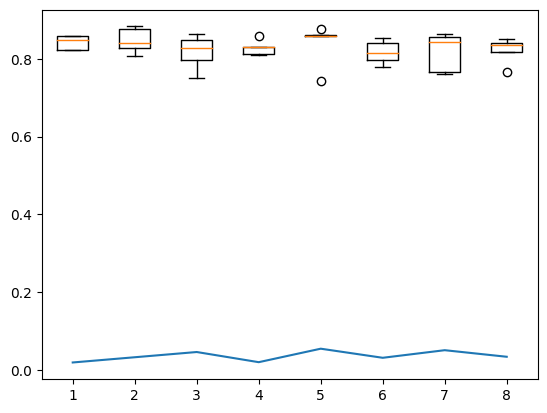

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"1(150, 150)HoleMakerBounded",0.842463,0.018615
"1(150, 150)HoleMakerAttention",0.847354,0.032071
"1(250, 250)HoleMakerBounded",0.817628,0.045534
"1(250, 250)HoleMakerAttention",0.828449,0.019379
"2(150, 150)HoleMakerBounded",0.839595,0.054080
"2(150, 150)HoleMakerAttention",0.817078,0.030675
"2(250, 250)HoleMakerBounded",0.818294,0.050217
"2(250, 250)HoleMakerAttention",0.822228,0.033311


We save the results in order to plot them together.

In [ ]:
folds = [["ResizeMix" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("ResizeMix")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


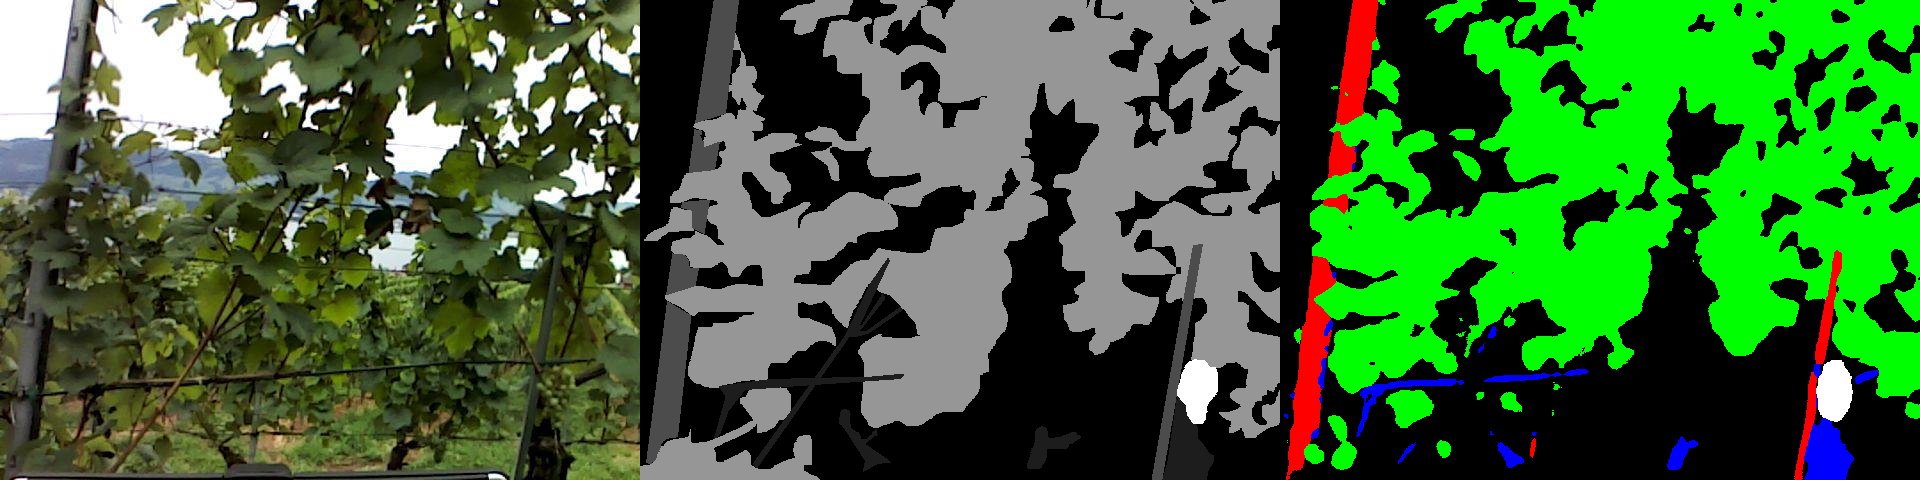

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

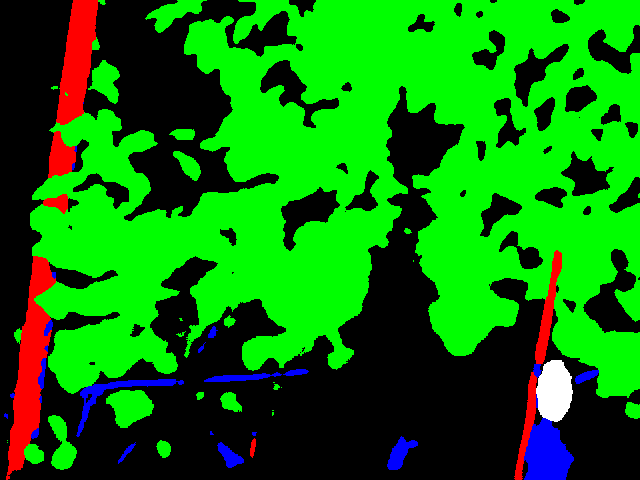

In [ ]:
mask